In [534]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['indices']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [794]:
# Define elements to use:

els = ['Fe', 'He', 'Mg', 'Ne', 'O', 'Si'] # TNG elements but removing C and N for proto-solar corrections

# Load training data:
full_input = '/mnt/store1/oliverphilcox/ChempyMultiData/All_Timestep_Training_Predictions.npz'
dat=np.load(full_input,mmap_mode='r')
all_els = dat['elements']
params=dat['params']
times=dat['timestep']

big_abun=dat.f.abundances
el_indices=np.zeros(len(els),dtype=int)
for e,el in enumerate(els):
    el_indices[e]=np.where(el==all_els)[0]
    
# Filter out unwanted elements
abun = big_abun[:,el_indices]


In [818]:
# Define elements to use:

els = ['Fe', 'He', 'Mg', 'Ne', 'O', 'Si'] # TNG elements but removing C and N for proto-solar corrections

# Load training data:
full_input = '/mnt/store1/oliverphilcox/Variable_Time_Test_Predictions.npz'
dat=np.load(full_input,mmap_mode='r')
all_els = dat['elements']
params=dat['params']

big_abun=dat.f.abundances
el_indices=np.zeros(len(els),dtype=int)
for e,el in enumerate(els):
    el_indices[e]=np.where(el==all_els)[0]
    
# Filter out unwanted elements
abun = big_abun[:,el_indices]


First remove any data which couldn't be sampled. (These regions in parameter space will be excluded from the priors).

In [819]:
bitmap=np.ones(len(params),dtype=int)
for i,ab in enumerate(abun):
    if ab[0]==0:
        bitmap[i]=0

In [820]:
cut_params=params[np.where(bitmap==1)]
cut_abuns=abun[np.where(bitmap==1)]

Also remove any NaN points (just one point in the extremal edges of parameter space so unimportant). We'll also remove any timesteps for $t<1$ here.

In [821]:
good_index=np.where(np.isfinite(cut_abuns[:,0]))[0]#&(params[:,-1]>0.99)))[0]
cut_params2=cut_params[good_index]
cut_abuns2=cut_abuns[good_index]
good_index2=np.where(cut_params2[:,-1]>0.99)[0]
cut_params3=cut_params2[good_index2]
cut_abuns3=cut_abuns2[good_index2]

Normalize these input parameters:

In [822]:
par_mean=np.mean(cut_params3,axis=0)
par_std=np.std(cut_params3,axis=0)
ab_mean=np.mean(cut_abuns3,axis=0)
ab_std=np.std(cut_abuns3,axis=0)

# Change t mean/std to give t in [-1,1]
par_mean[-1]=0.5*(max(cut_params3[:,-1])+min(cut_params3[:,-1]))
par_std[-1]=0.5*(max(cut_params3[:,-1])-min(cut_params3[:,-1]))

trainX=(cut_params3-par_mean)/par_std
trainY=(cut_abuns3-ab_mean)/ab_std

Only take a small subset for testing:

In [823]:
#indices=np.random.randint(0,len(trainX),100000)
#trainX=trainX[indices]
#trainY=trainY[indices]

Build neural net:

In [824]:
# Parameters
#neurons = 20
learning_rate = 0.05
epochs=200

In [825]:
n_train = len(trainX)

# Dimensions
dim_in = trainX.shape[1]
dim_out= trainY.shape[1]

import torch
from torch.autograd import Variable

# Convert to torch variables
tr_input = Variable(torch.from_numpy(trainX)).type(torch.FloatTensor)
tr_output = Variable(torch.from_numpy(trainY), requires_grad=False).type(torch.FloatTensor)

te_input = Variable(torch.from_numpy(testX),requires_grad=False).type(torch.FloatTensor)
te_output = Variable(torch.from_numpy(testY),requires_grad=False).type(torch.FloatTensor)

Define the neural network model:

In [826]:
hidden_layer_1, hidden_layer_2 = 10, 40

def one_layer_model(neurons=10):
    model = torch.nn.Sequential(
        torch.nn.Linear(dim_in,neurons),
        torch.nn.Tanh(),
        torch.nn.Linear(neurons,dim_out)
    )
    return model


#two_layer = torch.nn.Sequential(
#    torch.nn.Linear(dim_in,hidden_layer_1),
#    torch.nn.Tanh(),
#    torch.nn.Linear(hidden_layer_1,hidden_layer_2),
#    torch.nn.Tanh(),
#    torch.nn.Linear(hidden_layer_2,dim_out)
#    )


Create a training function:

In [827]:
def train_neural_network(model,epochs = epochs,learning_rate = learning_rate):
    loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')

    # Use Adam optimizer with learning rate specified in parameter.py
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.5,patience=4,threshold=1e-3)
    
    # For loss records
    losslog = []
    epoch = []
    
    # Train neural network
    for i in range(epochs):
        pred_output = model(tr_input)
        loss = loss_fn(pred_output, tr_output)
        optimizer.zero_grad() # Initially zero gradient
        loss.backward() # Backpropagation
        optimizer.step() # Update via optimizer
        scheduler.step(loss) # Update learning rate

        if i % 10 ==0:
            losslog.append(loss.data[0])
            epoch.append(i)
        if i % 10==0:
            print("Training epoch %d of %d complete" %(i,epochs))
    
    # Convert weights to numpy arrays
    model_numpy = []
    for param in model.parameters():
        model_numpy.append(param.data.numpy())

    print("L2 Loss value is {}".format(losslog[-1]))
    
    pred_validation = model(te_input)
    validation_loss = loss_fn(pred_validation,te_output)
    
    print("L2 Validation Loss is {}".format(validation_loss.data[0]))
    
    plt.plot(epoch,losslog,label=learning_rate)
    plt.ylabel("L2 Loss value")
    plt.xlabel("Epoch")
    plt.title("Loss plot")
    plt.legend()
    plt.show()
    
    return model_numpy,epoch,losslog,validation_loss


Now train the network:

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Training epoch 0 of 200 complete
Training epoch 10 of 200 complete
Training epoch 20 of 200 complete
Training epoch 30 of 200 complete
Training epoch 40 of 200 complete
Training epoch 50 of 200 complete
Training epoch 60 of 200 complete
Training epoch 70 of 200 complete
Training epoch 80 of 200 complete
Training epoch 90 of 200 complete
Training epoch 100 of 200 complete
Training epoch 110 of 200 complete
Training epoch 120 of 200 complete
Training epoch 130 of 200 complete
Training epoch 140 of 200 complete
Training epoch 150 of 200 complete
Training epoch 160 of 200 complete
Training epoch 170 of 200 complete
Training epoch 180 of 200 complete
Training epoch 190 of 200 complete
L2 Loss value is 0.008691891096532345
L2 Validation Loss is 0.03199639543890953


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


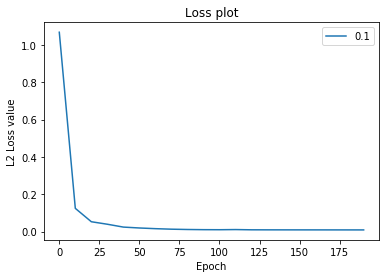

In [828]:
model_numpy,epoch,losslog,val_loss=train_neural_network(one_layer_model(15),epochs=200,learning_rate=0.1)

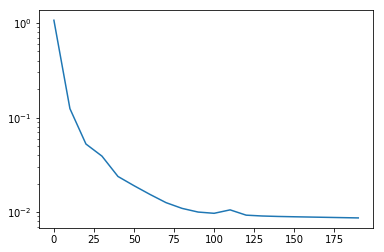

In [829]:
plt.plot(epoch,losslog)
plt.yscale('log')

In [830]:
np.savez("6element_neural_model.npz",
            w_array_0=model_numpy[0],
            b_array_0=model_numpy[1],
            w_array_1=model_numpy[2],
            b_array_1=model_numpy[3],
            input_mean=par_mean,
            input_std=par_std,
            output_mean=ab_mean,
            output_std=ab_std)

Now reconstruct neural network:

In [831]:
net_par=np.load("6element_neural_model.npz")
w0=np.asmatrix(net_par['w_array_0'])
w1=np.asmatrix(net_par['w_array_1'])
b0=np.asmatrix(net_par['b_array_0']).T
b1=np.asmatrix(net_par['b_array_1']).T
in_mean=net_par['input_mean']
in_std=net_par['input_std']
out_mean=net_par['output_mean']
out_std=net_par['output_std']

In [832]:
test_par=np.array([-2.4 , -2.85, -0.25 ,  0.65,  0.45, 7.3])
test_par_vector=np.asarray([test_par+0.01*u for u in range(4)])

In [833]:
def net_standard_output(standard_in_par):
    """Return neural network output (in standardized form)"""
    l1=np.matmul(w0,np.asmatrix(standard_in_par).T)+b0
    standard_out=np.matmul(w1,np.tanh(l1))+b1
    return standard_out
def net_output(in_par):
    """Return physics neural network output for destandardized parameters"""
    # Standardize input:
    standard_in=(in_par-in_mean)/in_std
    # Reconstruct network
    standard_out=net_standard_output(standard_in)
    # Destandardize output
    out = np.asarray(standard_out.T)*out_std+out_mean
    return out

Test this works:

In [834]:
net_output(test_par_vector)

array([[ 0.02940857,  0.00898801, -0.37199073, -0.06351657,  0.06435588,
         0.16741328],
       [ 0.03565399,  0.00264153, -0.37204888, -0.06383791,  0.06361065,
         0.16691827],
       [ 0.04178608, -0.0035851 , -0.37212263, -0.06414561,  0.06285714,
         0.16642125],
       [ 0.04780211, -0.0096897 , -0.37221195, -0.06444036,  0.06209556,
         0.16592246]])

Run Neural Network on the Test Set

In [835]:
# Load training data:
datT=np.load('/mnt/store1/oliverphilcox/Variable_Time_Test_Thin_Predictions.npz')
abunT=datT.f.abundances[:,el_indices]
elsT=datT.f.elements
paramsT=datT.f.params

bitmapT=np.ones(len(paramsT),dtype=int)
for i,ab in enumerate(abunT):
    if ab[0]==0:
        bitmapT[i]=0
                
# Remove dodgy data
cut_paramsT=paramsT[np.where(bitmapT==1)]
cut_abunsT=abunT[np.where(bitmapT==1)]
good_indexT=np.where(np.isfinite(cut_abunsT[:,0]))[0]
cut_params2T=cut_paramsT[good_indexT]
cut_abuns2T=cut_abunsT[good_indexT]

# Standardize using same standardizations as before
testX=(cut_params2T-par_mean)/par_std
testY=(cut_abuns2T-ab_mean)/ab_std

In [836]:
indices=np.random.randint(0,len(trainX),10000)

In [837]:
nn_testY=np.asarray(net_standard_output(testX).T)
nn_trainY=np.asarray(net_standard_output(trainX[indices]).T)

In [838]:
nn_all_trainY=np.asarray(net_standard_output(trainX).T)

(array([  15.,  132.,  633., 1784., 2780., 2615., 1476.,  470.,   84.,
          11.]),
 array([-1.82162733, -1.4496451 , -1.07766287, -0.70568064, -0.33369841,
         0.03828382,  0.41026605,  0.78224828,  1.15423051,  1.52621274,
         1.89819497]),
 <a list of 10 Patch objects>)

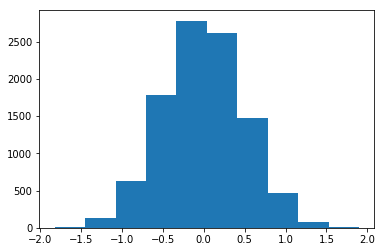

In [839]:
plt.hist(testX[:,2])

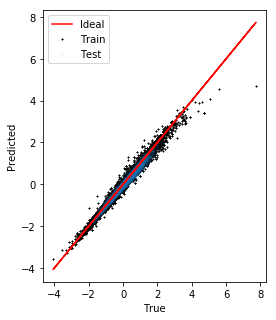

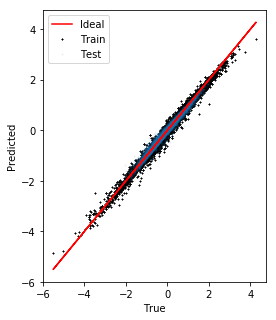

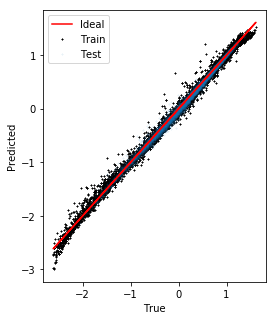

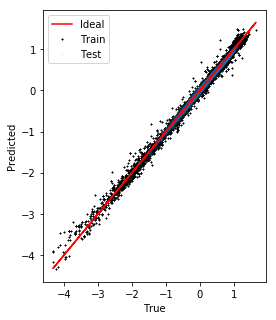

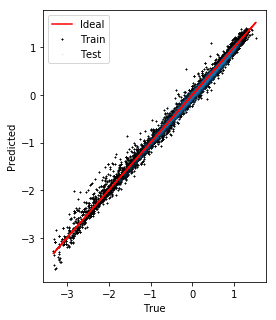

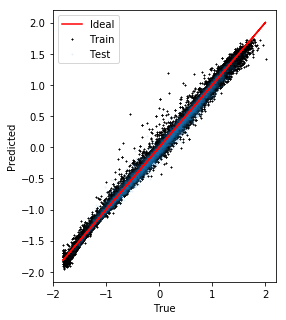

In [840]:
for index in range(6):
    plt.figure(figsize=(4,5))
    plt.scatter(trainY[indices,index],nn_trainY[:,index],c='k',marker='x',label='Train',s=1)
    plt.scatter(testY[:,index],nn_testY[:,index],alpha=0.1,marker='x',label='Test',s=1)
    plt.plot(trainY[indices,index],trainY[indices,index],c='r',label='Ideal');plt.legend();
    plt.ylabel('Predicted');plt.xlabel('True');

Look at data more carefully:

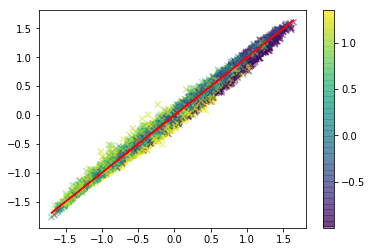

In [841]:
plt.scatter(testY[:,-1],nn_testY[:,-1],c=testX[:,5],marker='x',alpha=.5)
plt.plot(testY[:,-1],testY[:,-1],c='r');plt.colorbar();

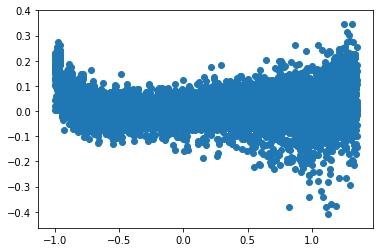

In [842]:
plt.scatter(testX[:,-1],testY[:,-1]-nn_testY[:,-1])

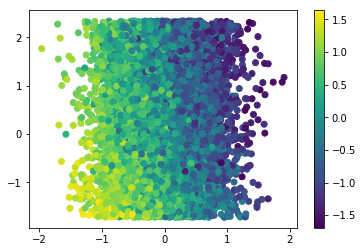

In [682]:
plt.scatter(testX[:,1],testX[:,5],c=testY[:,-1]);plt.colorbar()

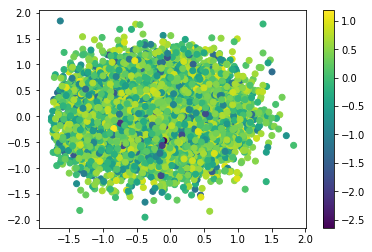

In [531]:
plt.scatter(testX[:,3],testX[:,4],c=testY[:,3]);plt.colorbar()